## PyTorch GCN with CORA dataset

In [1]:
import gcn
import torch
import matplotlib.pyplot as plt
import pandas as pd

from torch import nn
from pprint import pprint

In [2]:
df_nodes = pd.read_csv('data/cora-nodes.csv')
df_edges = pd.read_csv('data/cora-edges.csv')
df_labels = pd.read_csv('data/cora-labels.csv')

### Setup nodes

In [3]:
df_nodes = df_nodes.sort_values('paper_id')
df_nodes

,paper_id,word1,word10,word100,word1000,word1001,word1002,word1003,word1004,word1005,...,word990,word991,word992,word993,word994,word995,word996,word997,word998,word999
0,35,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,114,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,117,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1154500,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2704,1154520,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2705,1154524,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2706,1154525,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
nodes = df_nodes.iloc[:,1:].to_numpy()
nodes = torch.from_numpy(nodes).type(torch.float)
num_nodes = nodes.shape[0]

print(f"nodes: {nodes.shape}")
print(nodes)

nodes: torch.Size([2708, 1432])
tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


### Setup edges

In [5]:
df_edges

,citing_paper_id,cited_paper_id
0,35,210872
1,35,210871
2,35,82920
3,40,141342
4,128,114
...,...,...
5424,1154525,8591
5425,1154525,8594
5426,1155073,20857
5427,1155073,6923


In [6]:
adj = torch.zeros(num_nodes, num_nodes)
for row in df_edges.itertuples():
    src_id = row.citing_paper_id
    dst_id = row.cited_paper_id
    src_idx = df_nodes.index[df_nodes['paper_id'] == src_id].item()
    dst_idx = df_nodes.index[df_nodes['paper_id'] == dst_id].item()
    # using undirected edges
    adj[src_idx][dst_idx] = 1
    adj[dst_idx][src_idx] = 1

print(f"adjacency: {adj.shape}")
print(adj)

adjacency: torch.Size([2708, 2708])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


### Setup labels

In [7]:
label_mapping = sorted(df_labels['class_label'].unique())
label_mapping = {name: i for i, name in enumerate(label_mapping)}
label_mapping

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [8]:
num_classes = len(label_mapping)
labels = torch.zeros(num_nodes).type(torch.long)
for row in df_labels.itertuples():
    paper_id = row.paper_id
    node_id = df_nodes.index[df_nodes['paper_id'] == paper_id].item()
    label_id = label_mapping[row.class_label]
    labels[node_id] = label_id

print(f"labels: {labels.shape}")
print(labels[:15], '...')

labels: torch.Size([2708])
tensor([1, 1, 4, 4, 4, 4, 6, 4, 5, 4, 0, 3, 3, 1, 2]) ...


### Attempt to visualize graph

points:
tensor([[0.7700, 0.0514],
        [0.2464, 0.7038],
        [0.0019, 0.7920],
        ...,
        [0.2692, 0.6926],
        [0.1749, 0.0797],
        [0.3220, 0.4817]])


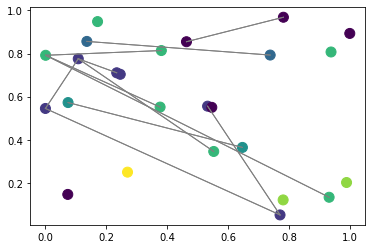

In [9]:
def plot_graph(adj, points, labels):
    for u, row in enumerate(adj):
        for v, connected in enumerate(row):
            if connected == 0:
                continue
            point_u = points[u]
            point_v = points[v]
            xs = [point_u[0], point_v[0]]
            ys = [point_u[1], point_v[1]]
            plt.plot(xs, ys, linewidth=1, c='gray')
    num_nodes = adj.shape[0]
    area = (torch.zeros(num_nodes) + 10) ** 2
    xs = points[:,0]
    ys = points[:,1]
    plt.scatter(xs, ys, s=area, c=labels)
    plt.show()

points = torch.rand(num_nodes, 2)
print(f"points:\n{points}")

plot_graph(adj[:25,:25], points[:25,:], labels[:25])

### Setup model

In [10]:
in_features = nodes.shape[1]
model = gcn.GraphConvNet(adj, 2, in_features, num_classes, is_sparse=True)
model

GraphConvNet(
  (prop_rule): Sequential(
    (0): GCNLayer(
      (linear): Linear(in_features=1432, out_features=16, bias=False)
    )
    (1): ReLU()
    (2): GCNLayer(
      (linear): Linear(in_features=16, out_features=7, bias=False)
    )
  )
)

### Try a single feed forward

logits: torch.Size([2708, 7])
tensor([[ 0.0021,  0.0117, -0.0470,  ..., -0.0062,  0.0646, -0.0225],
        [-0.0113,  0.0061, -0.0083,  ...,  0.0021,  0.0219,  0.0032],
        [-0.0017,  0.0004, -0.0278,  ...,  0.0010,  0.0252,  0.0136],
        ...,
        [-0.0035,  0.0200,  0.0039,  ..., -0.0027,  0.0179,  0.0106],
        [ 0.0042,  0.0017, -0.0139,  ...,  0.0020,  0.0212,  0.0055],
        [-0.0036,  0.0030, -0.0015,  ..., -0.0001,  0.0211,  0.0162]],
       grad_fn=<MmBackward>)
probabilities: torch.Size([2708, 7])
tensor([[0.1431, 0.1445, 0.1362,  ..., 0.1419, 0.1523, 0.1396],
        [0.1411, 0.1436, 0.1416,  ..., 0.1431, 0.1459, 0.1432],
        [0.1425, 0.1428, 0.1389,  ..., 0.1429, 0.1464, 0.1447],
        ...,
        [0.1417, 0.1450, 0.1427,  ..., 0.1418, 0.1447, 0.1437],
        [0.1431, 0.1428, 0.1406,  ..., 0.1428, 0.1456, 0.1433],
        [0.1420, 0.1429, 0.1422,  ..., 0.1424, 0.1455, 0.1448]],
       grad_fn=<SoftmaxBackward>)
y_predicted: tensor([5, 5, 5, 5, 5, 5,

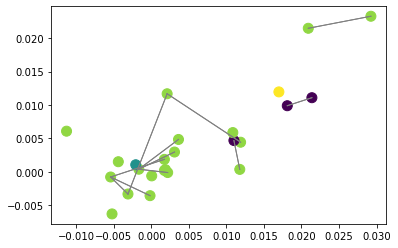

In [11]:
logits = model(nodes)
print(f"logits: {logits.shape}")
print(logits)

softmax = nn.Softmax(dim=1)
probs = softmax(logits)
print(f"probabilities: {probs.shape}")
print(probs)

y_pred = probs.argmax(dim=1)
correct = (y_pred == labels).type(torch.float).sum().item()
accuracy = (correct / num_nodes) * 100
print(f"y_predicted: {y_pred[:15]}")
print(f"true_labels: {labels[:15]}")
print(f"accuracy: {accuracy:>0.1f}%")

plot_graph(adj[:25,:25], logits.detach().numpy()[:25,:], y_pred[:25])

### Training

In [12]:
batch_size = num_nodes
learning_rate = 0.01
epochs = 200

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
for i in range(epochs):
    print(f"Epoch {i+1:<3} ------")
    gcn.train(nodes, labels, model, loss_fn, optimizer)
    gcn.evaluate(nodes, labels, model)
    print()
print("done")

Epoch 1   ------
loss: 1.948991
accuracy: 32.6%

Epoch 2   ------
loss: 1.914690
accuracy: 55.2%

Epoch 3   ------
loss: 1.872044
accuracy: 57.5%

Epoch 4   ------
loss: 1.825616
accuracy: 57.8%

Epoch 5   ------
loss: 1.773127
accuracy: 58.9%

Epoch 6   ------
loss: 1.716767
accuracy: 61.3%

Epoch 7   ------
loss: 1.657062
accuracy: 63.1%

Epoch 8   ------
loss: 1.592791
accuracy: 64.3%

Epoch 9   ------
loss: 1.524751
accuracy: 66.1%

Epoch 10  ------
loss: 1.453435
accuracy: 68.6%

Epoch 11  ------
loss: 1.379536
accuracy: 71.3%

Epoch 12  ------
loss: 1.304297
accuracy: 74.1%

Epoch 13  ------
loss: 1.228765
accuracy: 76.9%

Epoch 14  ------
loss: 1.152979
accuracy: 79.4%

Epoch 15  ------
loss: 1.077102
accuracy: 82.1%

Epoch 16  ------
loss: 1.002641
accuracy: 84.2%

Epoch 17  ------
loss: 0.930812
accuracy: 85.2%

Epoch 18  ------
loss: 0.861937
accuracy: 86.1%

Epoch 19  ------
loss: 0.796337
accuracy: 87.3%

Epoch 20  ------
loss: 0.734502
accuracy: 87.9%

Epoch 21  ------
los

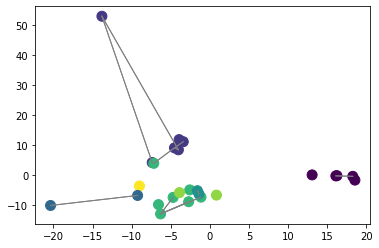

In [14]:
logits = model(nodes)
y_pred = softmax(logits).argmax(dim=1)
plot_graph(adj[:25,:25], logits.detach().numpy()[:25,:], y_pred[:25])